<a href="https://colab.research.google.com/github/yohanesnuwara/computational-geophysics/blob/master/seismic/seismic_extraction_on_well.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extraction of amplitude from 3D seismic data on well

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interpn

!pip -q install segyio
import segyio

!pip -q install lasio
import lasio

     |████████████████████████████████| 83 kB 1.6 MB/s 


In [2]:
!git clone https://github.com/yohanesnuwara/computational-geophysics

Cloning into 'computational-geophysics'...
remote: Enumerating objects: 567, done.
remote: Counting objects: 100% (330/330), done.
remote: Compressing objects: 100% (328/328), done.
remote: Total 567 (delta 205), reused 0 (delta 0), pack-reused 237
Receiving objects: 100% (567/567), 46.43 MiB | 19.25 MiB/s, done.
Resolving deltas: 100% (326/326), done.


In [3]:
import sys
sys.path.append('/content/computational-geophysics/seismic')

from seistool import openSegy3D, sliceCube

## 1. Load seismic data

In [4]:
!unzip '/content/computational-geophysics/seismic/SEISMIC3D.zip'
filepath = '/content/SEISMIC3D.sgy'

cube = openSegy3D(filepath)

Archive:  /content/computational-geophysics/seismic/SEISMIC3D.zip
  inflating: SEISMIC3D.sgy           
Successfully read 

Inline range from 1971 to 2121
Crossline range from 2775 to 2955
TWT from 999.0 to 1800.0
Sample rate: 3.0 ms
Survey rotation: 0.00 deg


Here the calculated survey rotation of 0 deg is incorrect. From the HRS software, the survey rotation is 45.282 deg. 

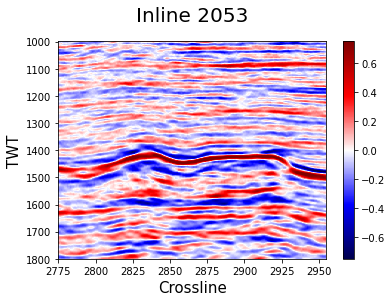

In [5]:
sliceCube(cube, 'il', inline_loc=2053, display=True, 
          cmap='seismic', vmin=-.75, vmax=.75)

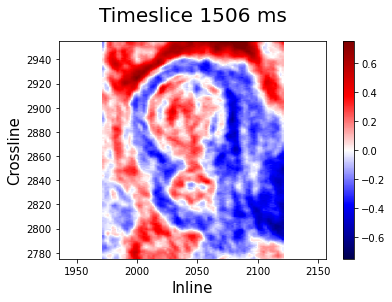

In [6]:
sliceCube(cube, 'ts', timeslice_loc=1506, display=True, 
          cmap='seismic', vmin=-.75, vmax=.75)

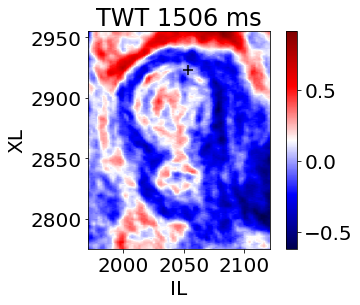

In [7]:
plt.rcParams['font.size'] = 20

twt = sliceCube(cube, 'ts', timeslice_loc=1506)
plt.imshow(twt.T, origin='lower', cmap='seismic',
           extent=(min(cube.inlines), max(cube.inlines), 
                   min(cube.crosslines), max(cube.crosslines)))
plt.colorbar()

# Well position
plt.scatter(2053, 2923, marker='+', color='black', s=100)
plt.xlabel('IL')
plt.ylabel('XL')
plt.title('TWT 1506 ms')
plt.show()

## 2. Open header information, locate coordinates, and convert SGY to Pandas DataFrame

In [8]:
def parseHeader(filename):
  """
  Parse header of a SEGY seismic volume
  """
  import segyio
  import re
  import pandas as pd

  def parse_trace_headers(segyfile, n_traces):
      '''
      Parse the segy file trace headers into a pandas dataframe.
      Column names are defined from segyio internal tracefield
      One row per trace
      '''
      # Get all header keys
      headers = segyio.tracefield.keys
      # Initialize dataframe with trace id as index and headers as columns
      df = pd.DataFrame(index=range(1, n_traces + 1),
                        columns=headers.keys())
      # Fill dataframe with all header values
      for k, v in headers.items():
          df[k] = segyfile.attributes(v)[:]
      return df


  def parse_text_header(segyfile):
      '''
      Format segy text header into a readable, clean dict
      '''
      raw_header = segyio.tools.wrap(segyfile.text[0])
      # Cut on C*int pattern
      cut_header = re.split(r'C ', raw_header)[1::]
      # Remove end of line return
      text_header = [x.replace('\n', ' ') for x in cut_header]
      text_header[-1] = text_header[-1][:-2]
      # Format in dict
      clean_header = {}
      i = 1
      for item in text_header:
          key = "C" + str(i).rjust(2, '0')
          i += 1
          clean_header[key] = item
      return clean_header  

  
  with segyio.open(filename, iline=5, xline=21) as f:  
    # Load headers
    n_traces = f.tracecount    
    bin_headers = f.bin
    text_headers = parse_text_header(f)
    trace_headers = parse_trace_headers(f, n_traces)

  return trace_headers 

In [9]:
header = parseHeader(filepath)

header

,TRACE_SEQUENCE_LINE,TRACE_SEQUENCE_FILE,FieldRecord,TraceNumber,EnergySourcePoint,CDP,CDP_TRACE,TraceIdentificationCode,NSummedTraces,NStackedTraces,DataUse,offset,ReceiverGroupElevation,SourceSurfaceElevation,SourceDepth,ReceiverDatumElevation,SourceDatumElevation,SourceWaterDepth,GroupWaterDepth,ElevationScalar,SourceGroupScalar,SourceX,SourceY,GroupX,GroupY,CoordinateUnits,WeatheringVelocity,SubWeatheringVelocity,SourceUpholeTime,GroupUpholeTime,SourceStaticCorrection,GroupStaticCorrection,TotalStaticApplied,LagTimeA,LagTimeB,DelayRecordingTime,MuteTimeStart,MuteTimeEND,TRACE_SAMPLE_COUNT,TRACE_SAMPLE_INTERVAL,...,AliasFilterFrequency,AliasFilterSlope,NotchFilterFrequency,NotchFilterSlope,LowCutFrequency,HighCutFrequency,LowCutSlope,HighCutSlope,YearDataRecorded,DayOfYear,HourOfDay,MinuteOfHour,SecondOfMinute,TimeBaseCode,TraceWeightingFactor,GeophoneGroupNumberRoll1,GeophoneGroupNumberFirstTraceOrigField,GeophoneGroupNumberLastTraceOrigField,GapSize,OverTravel,CDP_X,CDP_Y,INLINE_3D,CROSSLINE_3D,ShotPoint,ShotPointScalar,TraceValueMeasurementUnit,TransductionConstantMantissa,TransductionConstantPower,TransductionUnit,TraceIdentifier,ScalarTraceHeader,SourceType,SourceEnergyDirectionMantissa,SourceEnergyDirectionExponent,SourceMeasurementMantissa,SourceMeasurementExponent,SourceMeasurementUnit,UnassignedInt1,UnassignedInt2
1,1,1971,1971,1,0,2775,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,27,1726,27,1726,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1971,2775,1971,2775,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,1971,1971,2,0,2776,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,35,1735,35,1735,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1971,2776,1971,2776,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,1971,1971,3,0,2777,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,44,1744,44,1744,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1971,2777,1971,2777,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,1971,1971,4,0,2778,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,53,1753,53,1753,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1971,2778,1971,2778,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,5,1971,1971,5,0,2779,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,62,1761,62,1761,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1971,2779,1971,2779,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13752,177,2121,2121,177,0,2951,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,2909,1942,2909,1942,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2121,2951,2121,2951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13753,178,2121,2121,178,0,2952,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,2918,1951,2918,1951,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2121,2952,2121,2952,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13754,179,2121,2121,179,0,2953,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,2927,1960,2927,1960,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2121,2953,2121,2953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13755,180,2121,2121,180,0,2954,1,1,0,0,1,0,0,0,0,0,0,0,0,1,1,2936,1968,2936,1968,0,0,0,0,0,0,0,0,-999,0,999,0,0,268,3000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2121,2954,2121,2954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Here, CDP_X and CDP_Y give misleading information about the True Coordinates. It turns out this information is in SourceX and SourceY.

In [10]:
header[['SourceX', 'SourceY']]

,SourceX,SourceY
1,27,1726
2,35,1735
3,44,1744
4,53,1753
5,62,1761
...,...,...
13752,2909,1942
13753,2918,1951
13754,2927,1960
13755,2936,1968


In [11]:
# Function to get byte number of a given trace key
def get_byte(key_name):
  header = segyio.tracefield.keys
  return header[key_name]

get_byte('SourceX')

73

Convert the whole seismic data into Pandas DataFrame that consists of X, Y True Coordinates, TWT, and amplitude.

In [12]:
def seismic_to_df(filepath, key_x='CDP_X', key_y='CDP_Y'):
  # Get byte location of an attribute
  cdpx_byte, cdpy_byte = get_byte(key_x), get_byte(key_y)

  with segyio.open(filepath) as f:
    rot, cdpx, cdpy = segyio.tools.rotation(f)

    # Calculate number of trace
    n_traces = f.tracecount

    # TWT
    twt = f.samples

    # Empty dataframe
    df = pd.DataFrame(index=range(1, n_traces+1),
                      columns=[key_x, key_y])

    # List of CDPs per trace
    cdpx = [(f.attributes(cdpx_byte)[i])[0] for i in range(n_traces)]
    cdpy = [(f.attributes(cdpy_byte)[i])[0] for i in range(n_traces)]

    # Trace amplitudes
    tr = [f.trace.raw[i] for i in range(n_traces)] 

  df[key_x], df[key_y] = cdpx, cdpy
  df = df.astype({key_x: "int32", key_y: "int32"}) # To suppress memory

  # Repeat N times TWT of every row
  df = df.iloc[np.arange(len(df)).repeat(len(twt))]

  # Repeat TWT list
  twt = np.tile(twt, n_traces).astype("float32")
  df["TWT"] = twt

  # Flatten list of amplitudes
  tr = np.array(tr).flatten().astype("float32")
  df["Amplitude"] = tr  

  return df.reset_index(drop=True)

In [13]:
df = seismic_to_df(filepath, 'SourceX', 'SourceY')

df

,SourceX,SourceY,TWT,Amplitude
0,27,1726,999.0,-8.873796e-02
1,27,1726,1002.0,-1.996605e-01
2,27,1726,1005.0,-2.662140e-01
3,27,1726,1008.0,-2.440295e-01
4,27,1726,1011.0,-1.774760e-01
...,...,...,...,...
3686603,2945,1977,1788.0,4.436900e-02
3686604,2945,1977,1791.0,-3.255208e-09
3686605,2945,1977,1794.0,-6.655347e-02
3686606,2945,1977,1797.0,-1.552915e-01


## 3. Load well data

In [14]:
las = lasio.read('/content/computational-geophysics/seismic/WELL-01_logs.las')
well_df = las.df().reset_index()

well_df

,DEPTH,CHKS,RHOB,GR,NPHI,UNKNOWN,DT
0,100.0,711.05,NaN,NaN,NaN,NaN,NaN
1,200.0,715.08,NaN,NaN,NaN,NaN,NaN
2,300.0,719.11,NaN,NaN,NaN,NaN,NaN
3,400.0,723.14,NaN,NaN,NaN,NaN,NaN
4,500.0,727.17,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
12333,7128.0,NaN,2.4431,106.251,0.2429,NaN,NaN
12334,7128.5,NaN,2.5406,106.647,0.2435,NaN,NaN
12335,7129.0,NaN,NaN,106.950,0.2483,NaN,NaN
12336,7129.5,NaN,NaN,107.800,0.2524,NaN,NaN


This well has checkshot (T-D). There are missing checkshot values along the interval, so interpolate it. 

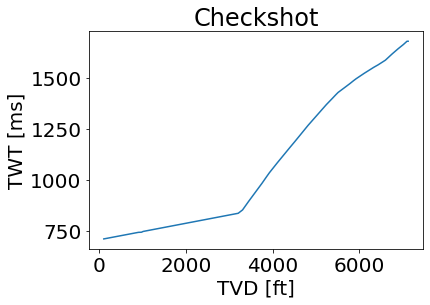

In [15]:
well_df['CHKS'] = well_df['CHKS'].interpolate(method='linear', axis=0)

plt.plot(well_df.DEPTH, well_df.CHKS)
plt.title('Checkshot')
plt.xlabel('TVD [ft]'); plt.ylabel('TWT [ms]')
plt.show()

This vertical well has wellhead coordinate (2002, 2378).

In [16]:
# Well coordinate
xw, yw = 2002, 2378

## 4. Rotate seismic and well coordinates to normal position

The purpose of rotation is to allow the extraction later on. We know the survey has been rotated by +45.282 deg. We will rotate the seismic once again by -45.282 deg, back to its NORMAL POSITION. We also need to rotate the well coordinate.

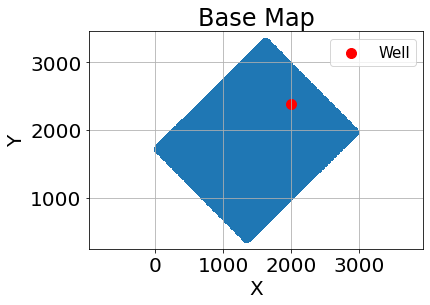

In [17]:
plt.scatter(df.SourceX, df.SourceY)
plt.scatter(xw, yw, s=100, color='r', label='Well')
plt.axis('equal')
plt.title('Base Map')
plt.xlabel('X'); plt.ylabel('Y')
plt.legend(loc='upper right', fontsize=15)
plt.grid()
plt.show()

In [18]:
def rotate_traj(trueEw, trueNs, rot):
  rotEw = (trueEw * np.cos(np.deg2rad(rot))) - (trueNs * np.sin(np.deg2rad(rot)))
  rotNs = (trueEw * np.sin(np.deg2rad(rot))) + (trueNs * np.cos(np.deg2rad(rot)))
  return rotEw, rotNs

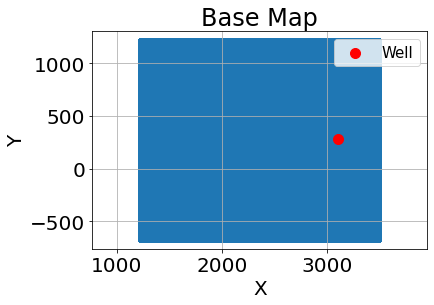

In [19]:
# Rotate by to its normal position
angle = -44.7 # I find out that -44.7 (instead of -45.3) gives the best position
wrot = rotate_traj(xw, yw, angle) # well
srot = rotate_traj(df.SourceX.values, df.SourceY.values, angle) # seismic

# Plot rotated base map
plt.scatter(srot[0], srot[1])
plt.scatter(wrot[0], wrot[1], s=100, color='r', label='Well')
plt.axis('equal')
plt.title('Base Map')
plt.xlabel('X'); plt.ylabel('Y')
plt.legend(loc='upper right', fontsize=15)
plt.grid()
plt.show()

## 5. Amplitude extraction

We use `interpn` (N-dimensional regular grid interpolation) from `SciPy` to extract amplitude. We need to define 3 inputs;
* `X_train`: Consists of X, Y coordinates, and TWT of seismic data, as tuples.
* `y_train`: Consists of seismic amplitudes, as meshgrid (or 2D array).
* `X_test`: Consists of X, Y coordinates, and TWT of well data, as 3D array.

Define the training feature `X_train`. We have rotated seismic to normal position.

In [20]:
# Bounds of the normal-rotated seismic coordinates
xmin, xmax = min(srot[0]), max(srot[0])
ymin, ymax = min(srot[1]), max(srot[1])

# Number of inlines and crosslines
nil, nxl = cube.data.shape[0], cube.data.shape[1]

# Divide x and y coordinates into regular intervals by number of IL and XL
x = np.linspace(xmin, xmax, nil)
y = np.linspace(ymin, ymax, nxl)
t = cube.twt

# Create X_train as tuple
X_train = (x, y, t)

Define the training target `y_train`.

In [21]:
# Create y_train as 2D array
y_train = cube.data

Define the test feature `X_test`. X, Y along the well is constant because the well is vertical. 

In [22]:
# Make array of constant X, Y coordinate values of rotated well
well_x = np.full(len(well_df), wrot[0])
well_y = np.full(len(well_df), wrot[1])

# Third axis is checkshot time (TWT)
well_t = well_df.CHKS

# Create X_test as 3D array
X_test = np.vstack([well_x, well_y, well_t]).T

Do the interpolation.

In [23]:
y_pred = interpn(X_train, y_train, X_test, bounds_error=False)

y_pred

array([        nan,         nan,         nan, ..., -0.31314107,
       -0.31314107, -0.31314107])

The result is extracted amplitude along the well. 

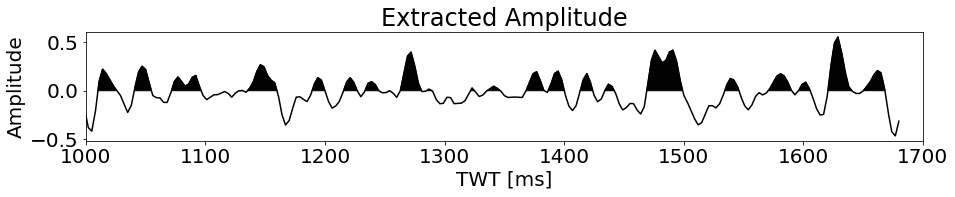

In [24]:
def fillWavelet(t, w):
  plt.fill_between(t, w, 0, w > 0.0, color='black')

plt.figure(figsize=(15,2))
plt.plot(well_df.CHKS, y_pred, color='black')
fillWavelet(well_df.CHKS, y_pred)
plt.xlim(1000,1700)
plt.title('Extracted Amplitude')
plt.xlabel('TWT [ms]')
plt.ylabel('Amplitude')
plt.show()

In [28]:
# Save extracted amplitude
well_trace = np.vstack([well_df.CHKS.values, y_pred]).T
np.savetxt('WELL-01_trace.txt', well_trace, fmt='%f')